In [6]:
import torch 
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

#normalizamos los datos
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,)),
                              ])
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=64, shuffle=True)

In [7]:
#Contruimos el feed-forward network
model = nn.Sequential(nn.Linear(784,128),
                      nn.ReLU(),
                      nn.Linear(128,64),
                      nn.ReLU(),
                      nn.Linear(64,10))

#Definimos la perdida, loss
criterion = nn.CrossEntropyLoss()

#Obtenemos nuestros datos
images,labels = next(iter(trainloader))

#Flatten
images = images.view(images.shape[0],-1)
logits = model(images)
loss = criterion(logits,labels)
print(loss)

tensor(2.3169, grad_fn=<NllLossBackward>)


# Ejercicio

In [12]:
model = nn.Sequential(nn.Linear(784,128),
                     nn.ReLU(),
                     nn.Linear(128,64),
                     nn.ReLU(),
                     nn.Linear(64,10),
                     nn.LogSoftmax(dim=1))

# cambiamos a NLLLoss
criterion= nn.NLLLoss()
images,labels = next(iter(trainloader))
images=images.view(images.shape[0],-1)

logps=model(images) #log probabilities
loss=criterion(logps,labels)
print(loss)


tensor(2.3334, grad_fn=<NllLossBackward>)



# Autograd
Calcula las gradientes que necesitamos

In [36]:
# Ejemplo
x = torch.zeros(1,requires_grad=True)
with torch.no_grad():
    y = x * 2
y.requires_grad

False

In [37]:
#Ejemplo 2
x = torch.randn(2,2,requires_grad=True)
print(x)

tensor([[ 1.1355,  1.2524],
        [-1.0700,  1.7596]], requires_grad=True)


In [38]:
y = x**2
y

tensor([[1.2893, 1.5686],
        [1.1450, 3.0961]], grad_fn=<PowBackward0>)

In [39]:
print(y.grad_fn) #tiene un historial, donde el pow (potencia) quedo grabado

In [40]:
z = y.mean()
print(z)

tensor(1.7747, grad_fn=<MeanBackward0>)


In [41]:
print(x.grad_fn)

None


In [42]:
z.backward()
print(x.grad)
print(x/2)

tensor([[ 0.5677,  0.6262],
        [-0.5350,  0.8798]])
tensor([[ 0.5677,  0.6262],
        [-0.5350,  0.8798]], grad_fn=<DivBackward0>)


In [66]:
# Ejemplo 3
x = torch.randn(1,2,requires_grad=True)
print(x)

tensor([[-0.5914, -1.0873]], requires_grad=True)


In [67]:
y = x **2

In [68]:
y

tensor([[0.3498, 1.1822]], grad_fn=<PowBackward0>)

In [69]:
y.grad_fn

In [70]:
z=torch.sum(y)

In [71]:
z

tensor(1.5320, grad_fn=<SumBackward0>)

In [72]:
z.backward()


In [73]:
x.grad

tensor([[-1.1829, -2.1746]])

In [74]:
print(2*x)

tensor([[-1.1829, -2.1746]], grad_fn=<MulBackward0>)



## Loss and Autograd together
Calcularemos el loss, las gradientes para los parametros seran calculados. Estas gradientes seran usadas para actualizar los pesos de la gradiente descendiente. 

In [80]:
model = nn.Sequential(nn.Linear(784,128),
                     nn.ReLU(),
                     nn.Linear(128,64),
                     nn.ReLU(),
                     nn.Linear(64,10),
                     nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
images,labels = next(iter(trainloader))
images = images.view(images.shape[0],-1) #flatten

logps = model(images)
loss = criterion(logps,labels)

In [81]:
print('Before backward pass: ',model[0].weight.grad)
loss.backward()
print('Before backward pass: ',model[0].weight.grad)

Before backward pass:  None
Before backward pass:  tensor([[-0.0017, -0.0017, -0.0017,  ..., -0.0017, -0.0017, -0.0017],
        [-0.0002, -0.0002, -0.0002,  ..., -0.0002, -0.0002, -0.0002],
        [ 0.0005,  0.0005,  0.0005,  ...,  0.0005,  0.0005,  0.0005],
        ...,
        [-0.0013, -0.0013, -0.0013,  ..., -0.0013, -0.0013, -0.0013],
        [ 0.0015,  0.0015,  0.0015,  ...,  0.0015,  0.0015,  0.0015],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


## Training the network
Necesitamos de un optimizador que usaremos para actualizar los pesos con las gradientes. 

In [82]:
from torch import optim
optimizer = optim.SGD(model.parameters(), lr=0.01)

El proceso de entrenamiento sera el siguiente:
* Hacemos un forward a traves de la red neuronal
* Usamos la salida de la red neuronal para calcular el loss
* Realizamos un pase backward a traves de la red con loss.backward() para calcular las gradientes
* Tomamos un paso con el optimizador para actualizar los pesos

In [85]:
print('Initial weights- ',model[0].weight)

images,labels = next(iter(trainloader))
images.resize_(64,784)

#Limpiamos las gradientes, hacemos esto para no acumularlo
optimizer.zero_grad()

#Hacemos un pase forward, 
output=model.forward(images)
loss=criterion(output,labels)
#despues un backward, para finalizar actualizando los pesos
loss.backward()
print('Gradient -',model[0].weight.grad)

Initial weights-  Parameter containing:
tensor([[ 0.0271,  0.0329, -0.0057,  ..., -0.0102, -0.0281, -0.0058],
        [ 0.0160,  0.0048,  0.0089,  ..., -0.0353,  0.0309, -0.0213],
        [ 0.0274, -0.0134, -0.0219,  ..., -0.0146, -0.0274,  0.0077],
        ...,
        [ 0.0042, -0.0038, -0.0111,  ..., -0.0310, -0.0030,  0.0323],
        [-0.0318,  0.0248, -0.0094,  ..., -0.0229,  0.0339, -0.0311],
        [-0.0002,  0.0034, -0.0283,  ..., -0.0265,  0.0188,  0.0024]],
       requires_grad=True)
Gradient - tensor([[-1.8466e-03, -1.8466e-03, -1.8466e-03,  ..., -1.8466e-03,
         -1.8466e-03, -1.8466e-03],
        [-9.1986e-05, -9.1986e-05, -9.1986e-05,  ..., -9.1986e-05,
         -9.1986e-05, -9.1986e-05],
        [ 3.6501e-04,  3.6501e-04,  3.6501e-04,  ...,  3.6501e-04,
          3.6501e-04,  3.6501e-04],
        ...,
        [ 8.8283e-04,  8.8283e-04,  8.8283e-04,  ...,  8.8283e-04,
          8.8283e-04,  8.8283e-04],
        [-9.4582e-04, -9.4582e-04, -9.4582e-04,  ..., -9.4582e-

# Ejercicio

In [87]:
model = nn.Sequential(nn.Linear(784,128),
                     nn.ReLU(),
                     nn.Linear(128,64),
                     nn.ReLU(),
                     nn.Linear(64,10),
                     nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(),lr=0.003)

epochs = 5
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        #hacemos plano la imagen, a un vector  de 784
        images=images.view(images.shape[0],-1)
        #training pass
        optimizer.zero_grad()
        
        output = model.forward(images)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
        
        running_loss+=loss.item()
        
    else:
        print('Trainig loss: {}'.format(running_loss/len(trainloader)))

Trainig loss: 1.8999119041316799
Trainig loss: 0.8732810502748753
Trainig loss: 0.5519429882134456
Trainig loss: 0.4449124358324354
Trainig loss: 0.39336270432291764


## Resultado del entrenamiento

In [97]:
import matplotlib.pyplot as plt
import numpy as np

'''
Copia de UDACITY:
'''
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

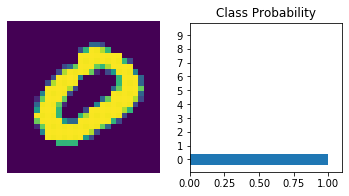

In [100]:
import helper
images, labels = next(iter(trainloader))
img = images[0].view(1,784)
with torch.no_grad():
    logits = model.forward(img)
    
ps = F.softmax(logits,dim=1)
view_classify(img.view(1,28,28),ps)